### SBAE notebook series - Part I - Sample size determination

The code snippets in this notebook will give a first idea of expected deforestation within a predefined Area of Interest based on Global Forest Cover data (Hansen et al 2013) for a given period of time.

Based on those deforestation estimates we can calculate the sample size based on an expected sampling error. In afirst step we apply the sample size calculation from Cochran.

Now that we have a rough idea of how much samples are needed, and thus how dense we need to sample our area, in order to arrive at a certain error, we re-run a sample simulation on the GFC data itself to see how much the expected error differs there.

Both analysis shall give us confidence in selecting an adequte sample size tat we can use in the following notebook, where we the actual sampling design is going to be created.

- todo
- write output to markdown to create a document
- 


In [11]:
import ee
ee.Initialize()

In [12]:
# period of change
start_year = 2015
end_year = 2020

# forest definition
tree_cover = 20         # in percent
mmu = 0.5               # in hectare

# aoi (various options)

# based on earth engine feature collection
country = 'Ethiopia'
gaul = ee.FeatureCollection("FAO/GAUL/2015/level1")
aoi = gaul.filter(ee.Filter.eq("ADM0_NAME", country)).union()

# any ogr/gdal readable vectorfile (e.g. shp, gpkg, geojson, kml)
#local_file = 'path/to/local/file'

In [16]:
import numpy as np
def apply_MMU(image, mmu=5):
    
    mask = image.gt(0).connectedPixelCount(ee.Number(mmu).add(2)).gte(ee.Number(mmu));
    return image.updateMask(mask);

def mmu_in_pixels(ha, scale):
    
    sqm = ha/100*1000*1000
    sqm_scale = scale*scale
    mmu = np.floor(sqm/sqm_scale)
    print(mmu)
    return mmu
    
def get_aoi_areas(aoi, collection, start=2001, end=2022, tree_cover=20, mmu=0.5):
    
    if collection == 'CCI':

        lc = ee.ImageCollection("users/amitghosh/sdg_module/esa/cci_landcover")
        lc_start = lc.filter(ee.Filter.eq("system:index", f'{start}')).first()
        lc_end = lc.filter(ee.Filter.eq("system:index", f'{end}')).first()
        change = lc_start.neq(lc_end).clip(aoi)
        scale = 300

    elif collection == 'GFC':
        
        scale = 30
        hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
        loss = hansen.select('lossyear').unmask(0)
        change = loss.gte(ee.Number(start).subtract(2000)).And(loss.lte(ee.Number(end).subtract(2000)))
        forest = hansen.select('treecover2000').updateMask(
            loss.gte(ee.Number(start).subtract(2000)).Or(loss.eq(0))
        ).gt(tree_cover).unmask(0)
        
        
    # -----------------------------------------------------------------
    # getting total area of change
    total_image = forest.addBands(change).addBands(ee.Image(1)).multiply(ee.Image.pixelArea()).rename(['forest_area', 'change_area', 'total_area'])
    areas = total_image.reduceRegion(**{
            'reducer': ee.Reducer.sum(),
            'geometry': aoi,
            'scale': scale,
            'maxPixels': 1e14
        })
    
    
    d, areas = {}, areas.getInfo()
    for area in areas.keys():
        d[area] = np.round(areas[area]/1000000,2)
    
    span = end-start+1
    print(f"According to the GFC product, the Area of Interest covers an area of {d['total_area']} square kilometers,"
          f" of which {d['forest_area']} square kilometers have been forested in {start} ({np.round(d['forest_area']/d['total_area']*100, 2)} %)."
          f" Between {start} and {end}, {d['change_area']} square kilometers have been deforested."
          f" That corresponds to {d['change_area']/span} square kilometers of annual deforestation in average."    
    )
    
    return d

area_dict = get_aoi_areas(aoi, 'GFC', 2015, 2020)
#yearly_dict = get_yearly_deforest_stats(aoi, 'GFC')


According to the GFC product, the Area of Interest covers an area of 1129313.53 square kilometers, of which 171269.48 square kilometers have been forested in 2015 (15.17 %). Between 2015 and 2020, 2244.88 square kilometers have been deforested. That corresponds to 374.1466666666667 square kilometers of annual deforestation in average.


According to the GFC product, the Area of Interest covers an area of 1129313.5 square kilometers, of which 161807.49 square kilometers have been forested in 2015 (14.33 %). Between 2015 and 2020, 2233.28 square kilometers have been deforested. That corresponds to 372.21333333333337 square kilometers of annual deforestation in average.

In [182]:
import numpy as np
import pandas as pd

def calculate_sample_size_cochran(total_area, subarea, z_score=1.645, target_precision=0.2):
    
    proportional_change = subarea/total_area
    error = target_precision * proportional_change
    return (z_score*z_score * proportional_change * (1 - proportional_change))/(error*error)


# we should invert that to do something similar as extrating from global data
def calculate_error_cochran(total_area, subarea, z_score=1.645, sample_size=250):
    
    proportional_change = subarea/total_area
    return np.sqrt((z_score*z_score * proportional_change * (1 - proportional_change))/sample_size)/proportional_change

In [183]:
d = {}
for idx, sample_size in enumerate(range(10000, 500000, 10000)):
    change_error = calculate_error_cochran(total_area = area_dict['total_area'],
        subarea = area_dict['change_area'],
        z_score=1.645,
        sample_size=sample_size)*100
    
    forest_error = calculate_error_cochran(total_area = area_dict['total_area'],
        subarea = area_dict['forest_area'],
        z_score=1.645,
        sample_size=sample_size)*100
    
    grid_size = np.sqrt(area_dict['total_area']/sample_size)
    d[idx] = sample_size, forest_error, change_error, grid_size
    
    
df = pd.DataFrame.from_dict(d, orient='index')

#display(df)
df.columns = ['Sample Size', 'Theoretical Sampling Error (Forest)', 'Theoretical Sampling Error (Deforestation)', 'Grid Size']
max_error = 10 # in percentage

selected = df[df['Theoretical Sampling Error (Deforestation)'] < max_error].head(1)

In [184]:
df

,Sample Size,Theoretical Sampling Error (Forest),Theoretical Sampling Error (Deforestation),Grid Size
0,10000,4.022476,36.954874,10.626916
1,20000,2.844320,26.131042,7.514365
2,30000,2.322377,21.335907,6.135453
3,40000,2.011238,18.477437,5.313458
4,50000,1.798906,16.526722,4.752501
5,60000,1.642169,15.086764,4.338420
6,70000,1.520353,13.967630,4.016597
7,80000,1.422160,13.065521,3.757182
8,90000,1.340825,12.318291,3.542305
9,100000,1.272018,11.686157,3.360526


In [185]:
selected_grid_size = int(np.floor(selected['Grid Size'])*1000)

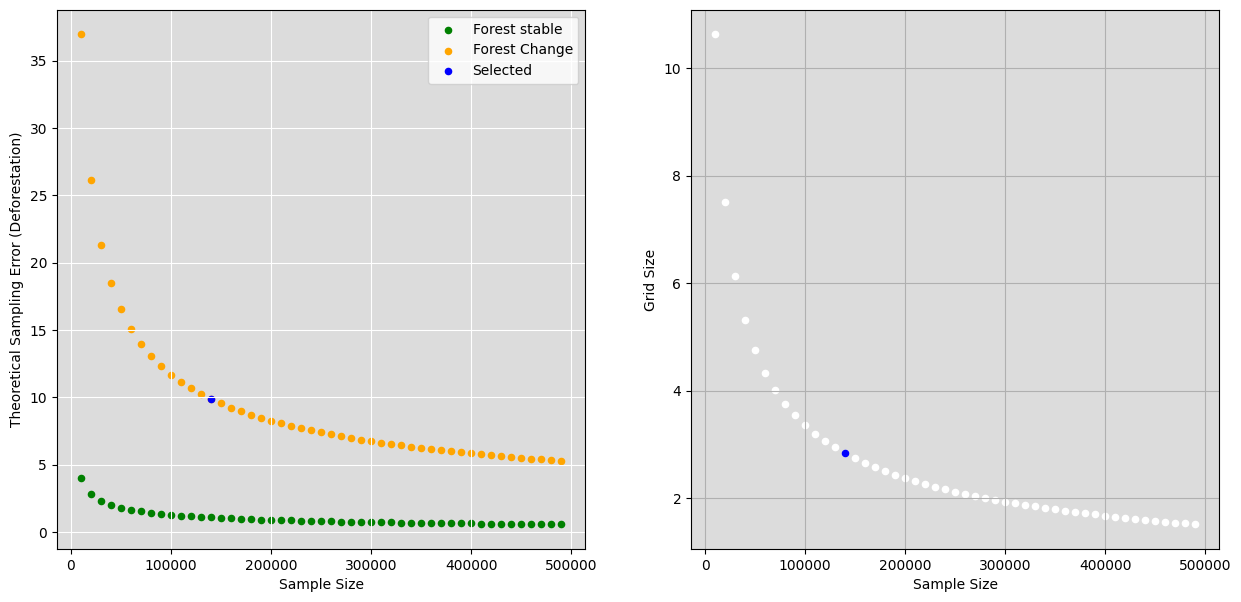

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
df.plot.scatter(y='Theoretical Sampling Error (Forest)', x='Sample Size', ax=axes[0], color='green')
df.plot.scatter(y='Theoretical Sampling Error (Deforestation)', x='Sample Size', ax=axes[0], color='orange')
selected.plot.scatter(y='Theoretical Sampling Error (Deforestation)', x='Sample Size', ax=axes[0], color='blue')
axes[0].legend(['Forest stable', 'Forest Change', 'Selected'])
df.plot(kind='scatter', x='Sample Size', y='Grid Size', ax=axes[1],color='white')
selected.plot(kind='scatter', x='Sample Size', y='Grid Size', ax=axes[1], color='blue')
axes[0].set_facecolor("gainsboro")
axes[0].grid(color='white')
axes[1].set_facecolor("gainsboro")
axes[1].grid()

In [187]:
def get_sampling_errors(aoi, start, end, collection, proportional_change, nr_of_runs_per_grid, grid_sizes, random_seed):    
    print(proportional_change)
    # create random seeds
    np.random.seed(random_seed)
    seeds = np.random.random(nr_of_runs_per_grid)
    seeds = list(np.round(np.multiply(seeds, 100), 0))
    
    if collection == 'CCI':

        lc = ee.ImageCollection("users/amitghosh/sdg_module/esa/cci_landcover")
        lc_start = lc.filter(ee.Filter.eq("system:index", f'{start}')).first()
        lc_end = lc.filter(ee.Filter.eq("system:index", f'{end}')).first()
        change = lc_start.neq(lc_end).clip(aoi)
        scale = 300

    elif collection == 'GFC':

        hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9").select('lossyear').unmask(0)
        change = hansen.gte(ee.Number(start).subtract(2000)).And(hansen.lte(ee.Number(end).subtract(2000)))
        scale = 30

    # -----------------------------------------------------------------
    # nested function for getting proportional change per grid size
    def get_grid_sample_error(grid):
        
        # set pixel size
        proj = ee.Projection("EPSG:3857").atScale(grid)
        
        # get total sample size
        sample_size = ee.Image(1).rename('sample_size').reproject(proj).reduceRegion(**{
            'reducer': ee.Reducer.sum(),
            'geometry': aoi,
            'scale': grid,
            'maxPixels': 1e14
        }).get('sample_size')
        
        
        # -----------------------------------------------------------------
        # nested function for getting proportional change per seed and grid
        def get_sampled_proportional_change(seed, proj):

            # create a subsample of our change image
            cells = ee.Image.random(seed).multiply(1000000).int().reproject(proj)
            random = ee.Image.random(seed).multiply(1000000).int()
            maximum = cells.addBands(random).reduceConnectedComponents(ee.Reducer.max())
            points = random.eq(maximum).selfMask().clip(aoi).reproject(proj.atScale(scale))

            # create a stack with change and total pixels as 1
            stack = (change.updateMask(points)          # masked sample change
                .addBands(points)                       # all samples
                .multiply(ee.Image.pixelArea())         # multiply both for pixel area
                .rename(['sampled_change', 'sampled_area'])
            )

            # sum them up
            areas = stack.reduceRegion(**{
                'reducer': ee.Reducer.sum(),
                'geometry': aoi,
                'scale': scale,
                'maxPixels': 1e14
            })

            # calculate proportional change to entire sampled area
            proportional_change_sampled = ee.Number(areas.get('sampled_change')).divide(ee.Number(areas.get('sampled_area'))).getInfo()
            print(proportional_change_sampled)
            error = (np.abs(proportional_change_sampled - proportional_change))/proportional_change*100
            
            return error
        # -----------------------------------------------------------------
        
        # get sample error mean and stddev
        sampling_iter = np.array([get_sampled_proportional_change(seed, proj) for seed in seeds])
        mean, stdDev = np.nanmean(sampling_iter), np.nanstd(sampling_iter)  
        
        # add to a dict of all grids
        #return ee.Dictionary({'stats': sampling_iter, 'size': sample_size})
        return mean, stdDev, sample_size.getInfo()
    
    d, dfs = {}, []
    # we map over all different grid sizes
    print(f" Running the sampling error simulation. Please be patient, this can take a while.")
    for idx, grid in enumerate(grid_sizes):
        print(f" Running {nr_of_runs_per_grid} times the sample error simulation at a scale of {grid} meter.")
        mean, stddev, sample_size = get_grid_sample_error(grid)
        d['idx'] = idx
        d['grid_size'] = grid
        d['sample_size'] = sample_size
        d['mean'] = mean
        d['stddev'] = stddev
        dfs.append(pd.DataFrame([d]))
    
    return pd.concat(dfs)

SUM over no runs (cproport change of individual run- mean proport change over all runs)**2/(no runs -1)

In [10]:
import numpy as np
dev = np.array([0.0019750643372405067,
0.0019227143767365303,
0.0019841186539092752,
0.0019446131488032859,
0.0020134178473816466,
0.0019643868855625307,
0.0019886682447074126,
0.002018196312343023,
0.001997622369266629,
0.0019886682447074126])

print(np.sqrt(np.sum([(i - np.mean(dev))**2 for i in dev])/(len(dev)-1)))

dev = np.array([0.002057814125929846,
0.0017400189136484985,
0.0019876950154372698,
0.0020431167379634666,
0.0021401626182764575,
0.001861493103971524,
0.0018790256692219356,
0.001864573382551955,
0.0019039771486011596,
0.0018790256692219356])

print(np.sqrt(np.sum([(i - np.mean(dev))**2 for i in dev])/(len(dev)-1)))

2.954255131517681e-05
0.00011890505260682086


In [190]:
grid_sizes = [selected_grid_size/2, selected_grid_size, selected_grid_size*2, selected_grid_size*4]
df = get_sampling_errors(aoi, start_year, end_year, 'GFC', area_dict['change_area']/area_dict['total_area'], 10, grid_sizes, 7)

0.001977555390952114
 Running the sampling error simulation. Please be patient, this can take a while.
 Running 10 times the sample error simulation at a scale of 1000.0 meter.
0.0019750643372405067
0.0019227143767365303
0.0019841186539092752
0.0019446131488032859
0.0020134178473816466
0.0019643868855625307
0.0019886682447074126
0.002018196312343023
0.001997622369266629
0.0019886682447074126
 Running 10 times the sample error simulation at a scale of 2000 meter.
0.0019801654282390366
0.0018765023133327304
0.001959918320282338
0.0020613059602999015
0.0019460693950155076
0.0019275843416228975
0.0018622605401970313
0.0019875048102828544
0.001973842127253029
0.0018622605401970313
 Running 10 times the sample error simulation at a scale of 4000 meter.
0.002057814125929846
0.0017400189136484985
0.0019876950154372698
0.0020431167379634666
0.0021401626182764575
0.001861493103971524
0.0018790256692219356
0.001864573382551955
0.0019039771486011596
0.0018790256692219356
 Running 10 times the samp

,idx,grid_size,sample_size,mean,stddev
0,0,1000.0,1.165370e+06,1.156995,0.825947
0,1,2000.0,2.913406e+05,2.683921,2.236443
0,2,4000.0,7.283469e+04,5.338841,2.918245
0,3,8000.0,1.820732e+04,100.000000,0.000000


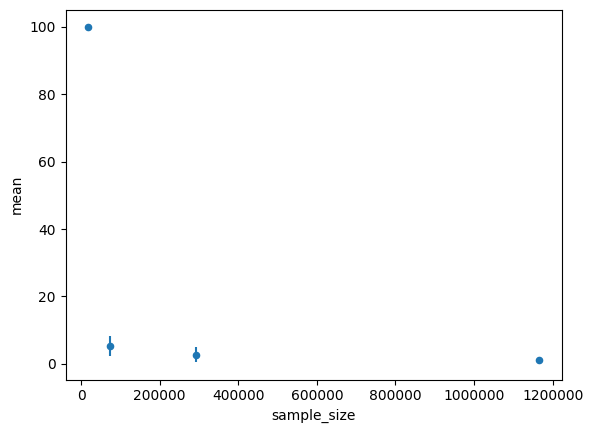

In [192]:
display(df)

#fig, ax = plt.subplots()
ax = df.plot(x='sample_size', y='mean', yerr='stddev', kind='scatter')
#ax.set_xscale('log')
ax.ticklabel_format(useOffset=False, style='plain')